<a href="https://colab.research.google.com/github/5ury4pr454th/fmml-labs/blob/master/Lab3_FMML20210108.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation

FMML Module 1, Lab 3<br>
 Module Coordinator: Thrupthi Ann John thrupthi.ann@research.iiit.ac.in <br>
 Release date: 18 October 2021 <br>

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=42)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically. 

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation. 

In [ ]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
# normalization
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels


11501568/11490434 [==============================] - 0s 0us/step


Let us borrow a few functions from the previous labs:

In [ ]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here 
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data 
  # and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [ ]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. 

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this. 

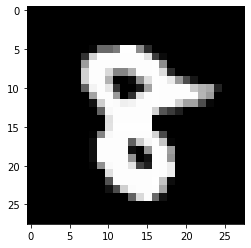

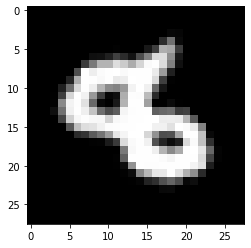

In [ ]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],45), cmap='gray')

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [ ]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  # here angle - 0.5 varies from -0.5 to +0.5. Multiplying by contraint does the job
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample. 
  # [[a]] - > [a], or [[a], [b]] ->   [[a], [b]] (depending on axis of squeezing, default is max axis)

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple. 

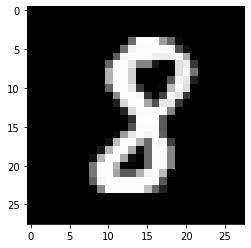

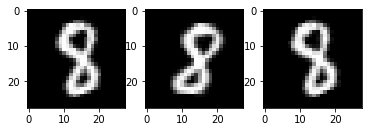

In [ ]:
sample = train_X[20] # take one image
angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

Let us augment the whole dataset and see if this improves the test accuracy

In [ ]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set 
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6616


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [ ]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6727
Accuracy after rotation augmentation constrained by  20  is  0.673
Accuracy after rotation augmentation constrained by  30  is  0.6737
Accuracy after rotation augmentation constrained by  40  is  0.6731
Accuracy after rotation augmentation constrained by  50  is  0.6701
Accuracy after rotation augmentation constrained by  60  is  0.6675
Accuracy after rotation augmentation constrained by  70  is  0.661
Accuracy after rotation augmentation constrained by  80  is  0.6462
Accuracy after rotation augmentation constrained by  90  is  0.6469


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

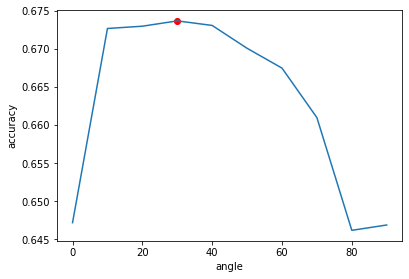

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

Let us try one more augmentation: shear. Here is what this looks like:

In [ ]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

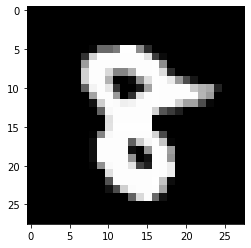

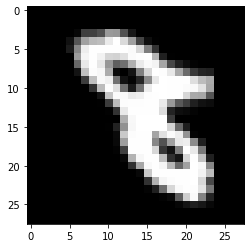

In [ ]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.4), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [ ]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [ ]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6147
Accuracy after shear augmentation constrained by  0.4  is  0.632
Accuracy after shear augmentation constrained by  0.6  is  0.6351
Accuracy after shear augmentation constrained by  0.8  is  0.6636
Accuracy after shear augmentation constrained by  1.0  is  0.6652
Accuracy after shear augmentation constrained by  1.2  is  0.6495
Accuracy after shear augmentation constrained by  1.4  is  0.6181
Accuracy after shear augmentation constrained by  1.6  is  0.6323
Accuracy after shear augmentation constrained by  1.8  is  0.6432
Accuracy after shear augmentation constrained by  2.0  is  0.6277


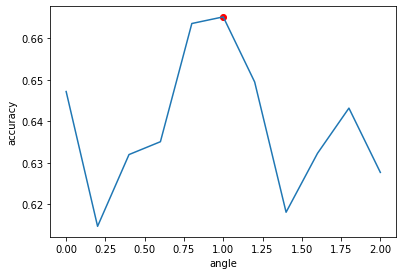

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters. 

In [ ]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii]) # first apply shear, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters. 

In [ ]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both (this is for grid search)

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][1], hyp[ii][0]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6332
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.64
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.631
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.6301
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.6329
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.6319
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.6252
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.6123
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.6196
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.6063
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.599
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.6032
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.603
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.5876
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.6295
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.6212


Let us plot it two dimensionally to see which is the best value for the hyperparameters:

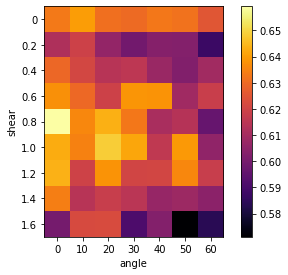

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno') 
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them. 
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch. 

## Answer for Question 1


The best value for angle constraint and shear constraint I got is for *angleconstraint* = 40 and *shear* = 0.00 (restricted to less than 0.4 to avoid any image distortions). 

Now the baseline accuracy we measured did not have any image augmentations at all. Thus, the dataset size was smaller in size, while **our augmentated dataset was bigger in size**. Also, we know that **train-test split matters**. 

Thus, to compensate, we will test our accuracy on the augmented dataset, as well as the original dataset, which we will upsample in size, using duplicate entries. We will do this by setting both angleconstraint and shear constraint to 0.00.

Therefore, we will compare the accuracies with two datasets, one with image augmentations, and another with just duplicate entries.

In [ ]:
constraints = [[0.00,0.00], [40, 0.00]]
test_accuracies = np.zeros(len(constraints), dtype=np.float) # we will save the values here

for ii in range(len(constraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, constraints[ii][0], constraints[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  test_accuracies[ii] = Accuracy(test_y, testpred)
print('Accuracy of dataset with duplicate data points is ',test_accuracies[0], flush=True)
print('Accuracy of dataset with augmented data points is ',test_accuracies[1], flush=True)

Accuracy of dataset with duplicate data points is  0.6332
Accuracy of dataset with augmented data points is  0.6279


Thus, the accuracy increased by 0.009.

---

## Answer for Question 2


In [ ]:
final_angle = 40
naugmentations = [1, 5, 25, 50, 75, 100]
accuracy_list = []

for naugmentations_i in naugmentations:
  augdata = train_X 
  auglabel = train_y

  for jj in range(naugmentations_i):
    augdata = np.concatenate((augdata, augRotate(train_X, final_angle)))
    auglabel = np.concatenate((auglabel, train_y))  

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  final_angle_accuracy = Accuracy(test_y, testpred)
  accuracy_list.append(final_angle_accuracy)
  print('Accuracy after rotation augmentation constrained by ', final_angle , 'with ', naugmentations_i, 'augmentation(s) per sample is ', final_angle_accuracy, flush=True)

Accuracy after rotation augmentation constrained by  40 with  1 augmentation(s) per sample is  0.6332
Accuracy after rotation augmentation constrained by  40 with  5 augmentation(s) per sample is  0.6684
Accuracy after rotation augmentation constrained by  40 with  25 augmentation(s) per sample is  0.6844
Accuracy after rotation augmentation constrained by  40 with  50 augmentation(s) per sample is  0.6847
Accuracy after rotation augmentation constrained by  40 with  75 augmentation(s) per sample is  0.6865
Accuracy after rotation augmentation constrained by  40 with  100 augmentation(s) per sample is  0.6853


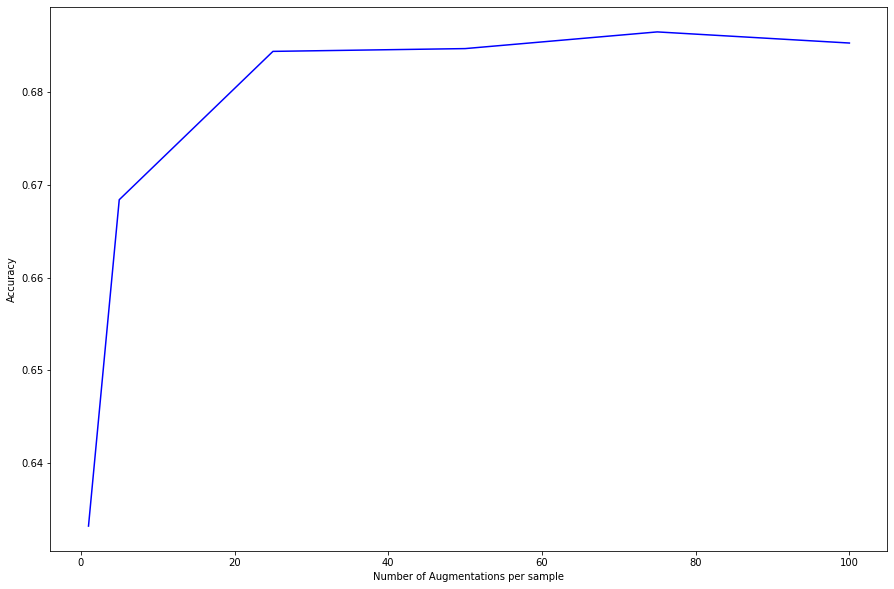

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(naugmentations, accuracy_list, color = 'blue')
plt.xlabel('Number of Augmentations per sample')
plt.ylabel('Accuracy')
plt.show()

Clearly, as we increased the number of augmented images from each sample, the accuracy improved. However, it saturates at within 25 augmentations itself.

---

## Answer for Question 3


The new augmentations that we will try out are:


1. Horizontal Shift
2. Vertical Shift
3. Random Shift
4. Random Noise 

We will not try flipping because flipping can change the meaning of the digit itself.

We will also not try blurring, because blurring for digits just increase the thickness of the lines, that is basically increasing the dataset.

In the next code block, we will define all the functions we will use:

In [ ]:
from skimage.transform import warp
from skimage.util import random_noise

class Shift:
  
  def __init__(self, amt, amt2 = None):
    self.amt = amt

    if amt2 == None:
      self.amt2 = self.amt
    else:
      self.amt2 = amt2
      

  def shift_vertical(self, xy, oamt = None):
    if oamt == None:
      xy[:, 1] += self.amt
    else:
      xy[:, 1] += oamt
      
    return xy

  def shift_horizontal(self, xy, oamt = None):
    if oamt == None:
      xy[:, 0] += self.amt
    else:
      xy[:, 0] += oamt
    return xy

  def general_shift(self, xy):
    # first parameter is horizontal, then is vertical
    return self.shift_vertical(self.shift_horizontal(xy, self.amt), self.amt2)

def augVshift(sample, shiftconstraint):
  if shiftconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  shift = rng.random(len(sample)) # generate random numbers for shifts
  shift = (shift-0.5)*shiftconstraint # make the random shift constrained
  # here shift - 0.5 varies from -0.5 to +0.5. Multiplying by contraint does the job
  nsample = sample.copy() # preallocate the augmented array to make it faster
  shift_object = Shift(shiftconstraint)
  for ii in range(len(sample)):
    shift_object.amt = shift[ii]
    nsample[ii] = warp(sample[ii], shift_object.shift_vertical)
  return np.squeeze(nsample) # take care if the input had only one sample. 
  # [[a]] - > [a], or [[a], [b]] ->   [[a], [b]] (depending on axis of squeezing, default is max axis)

def augHshift(sample, shiftconstraint):
  if shiftconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  shift = rng.random(len(sample)) # generate random numbers for shifts
  shift = (shift-0.5)*shiftconstraint # make the random shift constrained
  # here shift - 0.5 varies from -0.5 to +0.5. Multiplying by contraint does the job
  nsample = sample.copy() # preallocate the augmented array to make it faster
  shift_object = Shift(shiftconstraint)
  for ii in range(len(sample)):
    shift_object.amt = shift[ii]
    nsample[ii] = warp(sample[ii], shift_object.shift_horizontal)
  return np.squeeze(nsample) # take care if the input had only one sample. 
  # [[a]] - > [a], or [[a], [b]] ->   [[a], [b]] (depending on axis of squeezing, default is max axis)

def augRshift(sample, shiftconstraint):
  if shiftconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  shift1 = rng.random(len(sample)) # generate random numbers for shifts
  shift1 = (shift1-0.5)*shiftconstraint # make the random shift constrained
  shift2 = rng.random(len(sample)) # generate random numbers for shifts
  shift2 = (shift1-0.5)*shiftconstraint # make the random shift constrained
  # here shift - 0.5 varies from -0.5 to +0.5. Multiplying by contraint does the job
  nsample = sample.copy() # preallocate the augmented array to make it faster
  shift_object = Shift(shiftconstraint, shiftconstraint)
  for ii in range(len(sample)):
    shift_object.amt = shift1[ii]
    shift_object.amt2 = shift2[ii]
    nsample[ii] = warp(sample[ii], shift_object.general_shift)
  return np.squeeze(nsample) # take care if the input had only one sample. 
  # [[a]] - > [a], or [[a], [b]] ->   [[a], [b]] (depending on axis of squeezing, default is max axis)

def augNoise(sample, noise_paramconstraint):
  if noise_paramconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  noise_param = rng.random(len(sample)) # generate random numbers for noise_params
  noise_param = (noise_param-0.5)*noise_paramconstraint # make the random noise_param constrained
  # here noise_param - 0.5 varies from -0.5 to +0.5. Multiplying by contraint does the job
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = random_noise(sample[ii], mode='gaussian', mean = noise_param[ii])
  return np.squeeze(nsample) # take care if the input had only one sample. 
  # [[a]] - > [a], or [[a], [b]] ->   [[a], [b]] (depending on axis of squeezing, default is max axis)

def augRotateVshift(sample, angleconstraint, vshiftconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for vshift
  amt = (amt-0.5)*vshiftconstraint # make the random vshift constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  
  shift_object = Shift(vshiftconstraint)
  for ii in range(len(sample)):
    shift_object.amt = amt[ii]
    nsample[ii] = rotate(warp(sample[ii], shift_object.shift_vertical), angle[ii]) # first apply vshift, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample.

Here are some visualizations of the augmentations...

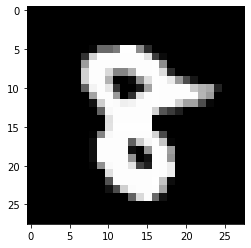

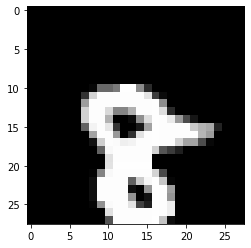

In [ ]:
# shifting down by setting amt to -5 and passing vertical shifting function
plt.imshow(train_X[2], cmap='gray')
plt.show()
shift_object = Shift(-5)
plt.imshow(warp(train_X[2], shift_object.shift_vertical), cmap='gray')

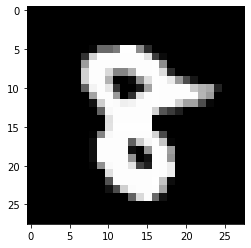

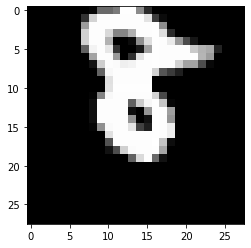

In [ ]:
# shifting up by setting amt to 5 and passing vertical shifting function
plt.imshow(train_X[2], cmap='gray')
plt.show()
shift_object.amt = 5
plt.imshow(warp(train_X[2], shift_object.shift_vertical), cmap='gray')

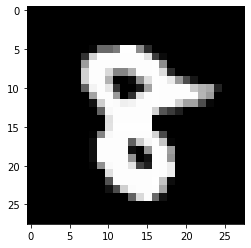

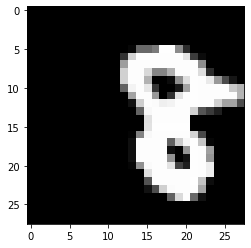

In [ ]:
# shifting right by setting amt to -5 and passing horizontal shifting function
plt.imshow(train_X[2], cmap='gray')
plt.show()
shift_object.amt = -5
plt.imshow(warp(train_X[2], shift_object.shift_horizontal), cmap='gray')

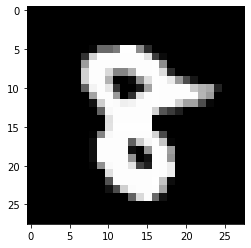

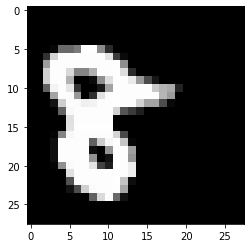

In [ ]:
# shifting left by setting amt to 5 and passing horizontal shifting function
plt.imshow(train_X[2], cmap='gray')
plt.show()
shift_object.amt = 5
plt.imshow(warp(train_X[2], shift_object.shift_horizontal), cmap='gray')

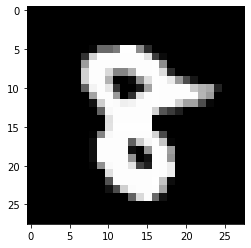

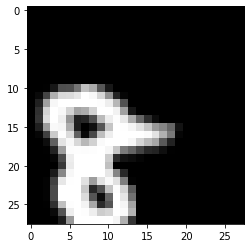

In [ ]:
# shifting left by setting amt to 5 and passing horizontal shifting function
plt.imshow(train_X[2], cmap='gray')
plt.show()
random_shift = Shift(5.25, -5.25)
plt.imshow(warp(train_X[2], random_shift.general_shift), cmap='gray')

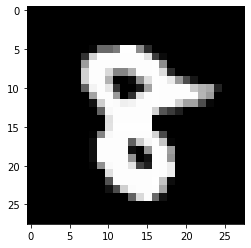

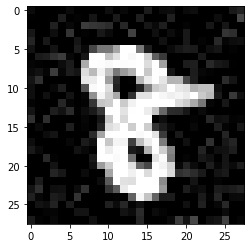

In [ ]:
# adding random gaussian noise
noise_img = random_noise(train_X[2], mode='gaussian')
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(noise_img, cmap='gray')

In [ ]:
Vshiftconstraints = [0, 2, 4, 8, 16] # the values we want to test
accuracies = np.zeros(len(Vshiftconstraints), dtype=np.float) # we will save the values here
naugmentations = 5

for ii in range(len(Vshiftconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augVshift(train_X, Vshiftconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after Vshift augmentation constrained by ',Vshiftconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after Vshift augmentation constrained by  0  is  0.6472
Accuracy after Vshift augmentation constrained by  2  is  0.6731
Accuracy after Vshift augmentation constrained by  4  is  0.6675
Accuracy after Vshift augmentation constrained by  8  is  0.6297
Accuracy after Vshift augmentation constrained by  16  is  0.6053


In [ ]:
Hshiftconstraints = [0, 2, 4, 8, 16] # the values we want to test
accuracies = np.zeros(len(Hshiftconstraints), dtype=np.float) # we will save the values here
naugmentations = 5

for ii in range(len(Hshiftconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augHshift(train_X, Hshiftconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after Hshift augmentation constrained by ',Hshiftconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after Hshift augmentation constrained by  0  is  0.6472
Accuracy after Hshift augmentation constrained by  2  is  0.6603
Accuracy after Hshift augmentation constrained by  4  is  0.6528
Accuracy after Hshift augmentation constrained by  8  is  0.6267
Accuracy after Hshift augmentation constrained by  16  is  0.6029


In [ ]:
Rshiftconstraints = [0, 2, 3, 4, 5] # the values we want to test
accuracies = np.zeros(len(Rshiftconstraints), dtype=np.float) # we will save the values here
naugmentations = 5

for ii in range(len(Rshiftconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRshift(train_X, Rshiftconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after Rshift augmentation constrained by ',Rshiftconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after Rshift augmentation constrained by  0  is  0.6472
Accuracy after Rshift augmentation constrained by  2  is  0.646
Accuracy after Rshift augmentation constrained by  3  is  0.6362
Accuracy after Rshift augmentation constrained by  4  is  0.5941
Accuracy after Rshift augmentation constrained by  5  is  0.5684


In [ ]:
Noiseconstraints = [0, 0.2, 0.4, 0.8] # the values we want to test
accuracies = np.zeros(len(Noiseconstraints), dtype=np.float) # we will save the values here
naugmentations = 5

for ii in range(len(Noiseconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augNoise(train_X, Noiseconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after Noise augmentation constrained by ',Noiseconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after Noise augmentation constrained by  0  is  0.6472
Accuracy after Noise augmentation constrained by  0.2  is  0.6506
Accuracy after Noise augmentation constrained by  0.4  is  0.65
Accuracy after Noise augmentation constrained by  0.8  is  0.654


Therefore, we see that all of the above augmentations do increase the accuracies.

---

## Answer for Question 4

Till now, the best accuracy I can get is with vertical Shift and rotation combination...

In [ ]:
constraints = [[0.00,0.00], [40, 2]]
test_accuracies = np.zeros(len(constraints), dtype=np.float) # we will save the values here

for ii in range(len(constraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateVshift(train_X, constraints[ii][0], constraints[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  test_accuracies[ii] = Accuracy(test_y, testpred)
print('Accuracy of dataset with duplicate data points is ',test_accuracies[0], flush=True)
print('Accuracy of dataset with augmented data points is ',test_accuracies[1], flush=True)

Accuracy of dataset with duplicate data points is  0.6472
Accuracy of dataset with augmented data points is  0.6859


Thus, it looks like rotation and vertical shifting works very well. Thus, the above accuracy is the highest accuracy we have achieved.

In [ ]:
# now we check our lowest training data size
from sklearn.model_selection import train_test_split
test_accuracies = [] # we will save the values here
variations = [0.50, 0.25, 0.10, 0.0625, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001]

try:
  for i in variations:
    # create the augmented dataset
    augdata, i_, auglabel, n_ = train_test_split(train_X, train_y, train_size = i)

    for jj in range(naugmentations):
      augdata = np.concatenate((augdata, augRotateVshift(train_X, 40, 2))) # concatenate the augmented data to the set
      auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    current_acc = Accuracy(test_y, testpred)
    test_accuracies.append(current_acc)
    print(f'Accuracy with {i*100}% data :', current_acc, flush=True)
except ValueError:
  print("Now, the train data cannot be split anymore and thus, the lowest we can go is with the previous percentage of data!")

Accuracy with 50.0% data : 0.6847
Accuracy with 25.0% data : 0.6813
Accuracy with 10.0% data : 0.6866
Accuracy with 6.25% data : 0.7012
Accuracy with 5.0% data : 0.6753
Accuracy with 2.5% data : 0.683
Now, the train data cannot be split anymore and thus, the lowest we can go is with the previous percentage of data!


Text(0, 0.5, 'accuracy')

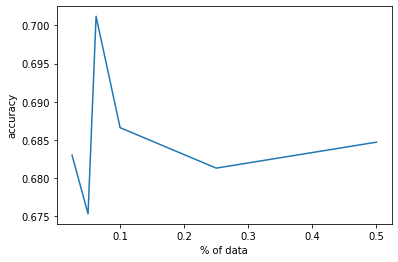

In [ ]:
# plot the variation of accuracy
plt.plot(variations[0:len(test_accuracies)], test_accuracies)
plt.xlabel('% of data')
plt.ylabel('accuracy')

---
